<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Pyro 101
</div>

- Parameter point estimate
- SVI
- MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)

print(f"Using {device}")
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

torch.set_default_dtype(torch.float32)

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
0 : Generate synthetic data
</div>

In [4]:
a = torch.tensor([5.0])
b = torch.tensor([-1.0])
noise = torch.tensor([0.1])

N_POINTS = 100

X = torch.linspace(0.0, 1.0, steps=N_POINTS)
y = a * X + b + torch.randn(N_POINTS) * noise

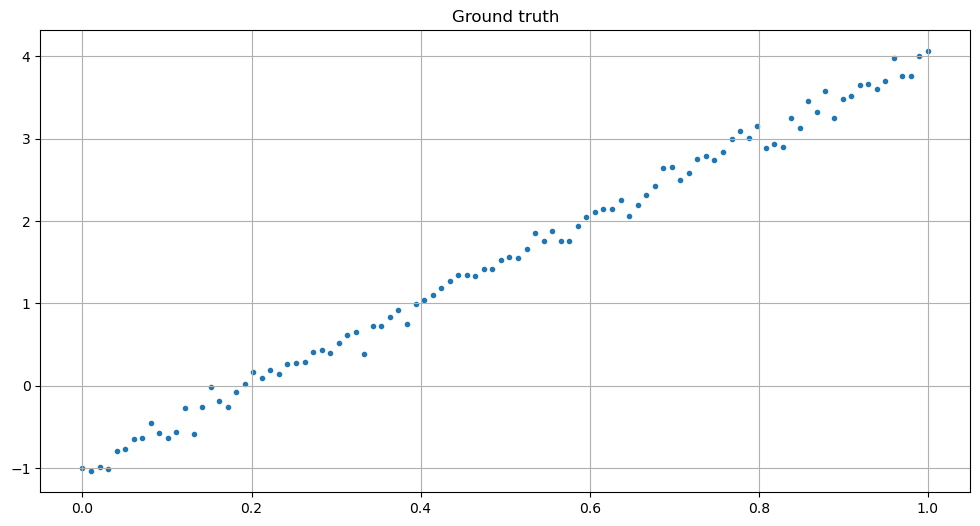

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X.cpu(),y.cpu(),label='ground truth', marker='.')
ax.grid()
ax.set_title(f'Ground truth')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
1 : learnable parameters for MLE
</div>

In Pyro, the `def model()` function is to be seen as a definition of the generative model, not as a function in the Python sense.

- `def model(X, y=None)` defines $p_{\theta}(x \vert z)p(z)$

Primitives:
- `pyro.param(name, dist, *args)`
  - the Torch.tensor wrapped in `pyro.param` becomes learnable parameters (wrt Optimizer)
  - the Torch.tensor in `pyro.param` is stored in the global Pyro Parameter Store (`pyro.get_param_store()`)
  - at initialisation `pyro.param(name, initial_value, ...)` : if `name` already exists, then the current value is returned. Else, `name`is created into the Store and the value is stored.
  - constraints can be enforced : `constraint=constraints.positive` for example (typically for variances or standard deviations)
  - typical use : use in `model`, without any `pyro.sample`, for Maximum Likelihood Estimation
  - other typical use : parameters in the approximate posterior ("`guide`") for the Stochastic Variational Inference (SVI)


- `pyro.sample(name, dist, *args)`
  - the core declarative statement of a Random Variable in Pyro
  - creates a stochastic *site* (ie Random Variable RV), ie declares the `name` as a random variable from the `dist`
  - `name` is mandatory and unique. Allows Pyro's inference algorythms (SVI...) and handlers (`trace`, `replay`,...) to track, manipulate, condition on that variable.
  - **the behavior of `pyro.sample` changes based on the context** (ie which handlers or algorithms are running it):
    - context `model` with no `obs` : draws a random value from the distribution (=> generates a prior sample or a prediction $\hat{y}$)
    - context `model` with `obs`: does not draw a sample. Returns the observation $y$ and compute the log prob $\log{p(y)}$ (=> defines the likelihood term for the ELBO calculation)
    - context *`guide`* (ie $q_{\phi}(z \vert x)$) : draws a random value from the *guide* (ie approximate posterior) (=> generate $z \sim q_{\phi}(z \vert x)$ for the gradient of ELBO calculation). (So `pyro.sample` in a *guide* never takes an `obs` argument.)
    - context `trace` : records the resulting random value and log-prob in the trace object (=> enables advanced handling like `replay`)
  - the parameters of the distribution inside `pyro.sample` can be learnable `pyro.param`


- `def model(X, y=None)`
  - Training, ELBO calculation : `y is not None`: priors are sampled (if any), the log-likelihood is computed in `pyro.sample("obs", dist, obs=y)`. The `model(X,y)` returns $\hat{y}$ which is either the log-likelihood or the observation itself, depending on the handlers.
  - Prediction, sampling : `y=None` : when `model` is called outside the SVI training loop. 
    - if `model` is not under a `replay` : it uses samples from the priors
    - if `model` is under `replay` : it uses values sampled from the *guide* (approximate posterior) and stored in a `trace`
    - `pyro.sample("obs",...,obs=None)` is executed : a random sample is drawn from the likelihood distribution.

In [6]:
# Simple Bayesian linear regression model with parameters only

def model(X, y=None):
    
    # inputs: ----------------------
    #   X : torch.tensor(size,1)
    #   y : torch.tensor(size,1) if provided
    
    # learnable parameters ------------------------
    param_a = pyro.param("param_a", torch.tensor((0.)))
    param_b = pyro.param("param_b", torch.tensor((0.)))
    param_noise = pyro.param("param_noise", torch.tensor((1.0)), constraint=constraints.positive)
    
    # priors ---------------------------------
    # No prior here, we run a simple parameter MLE
    
    # gaussian likelihood ----------------------------
    means = X * param_a + param_b
    with pyro.plate("data", len(X)):
        y_hat = pyro.sample("obs", dist.Normal(means, param_noise), obs=y)
    
    # return is optional :
    #   - If y is None, this is a sample (tensor)
    #   - If y is given, this is the log likelihood
    return y_hat

In [7]:
# log likelihood
print(model(X,y))

tensor([-0.9897, -1.0351, -0.9792, -1.0076, -0.7933, -0.7658, -0.6491, -0.6308,
        -0.4527, -0.5718, -0.6335, -0.5545, -0.2715, -0.5833, -0.2565, -0.0102,
        -0.1830, -0.2568, -0.0777,  0.0213,  0.1657,  0.1018,  0.1905,  0.1433,
         0.2609,  0.2826,  0.2912,  0.4117,  0.4345,  0.4041,  0.5205,  0.6127,
         0.6576,  0.3889,  0.7294,  0.7254,  0.8391,  0.9243,  0.7503,  0.9991,
         1.0455,  1.0997,  1.1879,  1.2728,  1.3435,  1.3505,  1.3300,  1.4172,
         1.4159,  1.5226,  1.5658,  1.5501,  1.6645,  1.8513,  1.7593,  1.8801,
         1.7626,  1.7524,  1.9446,  2.0510,  2.1091,  2.1431,  2.1456,  2.2555,
         2.0590,  2.1942,  2.3158,  2.4242,  2.6445,  2.6580,  2.4987,  2.5813,
         2.7478,  2.7833,  2.7384,  2.8408,  2.9893,  3.0913,  3.0024,  3.1463,
         2.8839,  2.9352,  2.8974,  3.2506,  3.1263,  3.4595,  3.3277,  3.5743,
         3.2546,  3.4740,  3.5179,  3.6479,  3.6593,  3.6023,  3.7005,  3.9764,
         3.7622,  3.7635,  4.0028,  4.05

In [8]:
# sample y
y_hat = model(X)
print(y_hat)

tensor([-1.4489, -1.2908, -0.7772, -2.1880,  0.5534,  1.0456, -0.4095, -2.3746,
         0.0270,  0.7534, -0.5616,  2.1299, -0.8812, -1.3345, -0.5862, -0.5570,
        -0.0860, -0.9313, -0.5014, -1.2949,  0.0580, -0.1886, -0.0626,  1.1548,
         0.9268,  0.3471, -0.1943, -0.4784,  0.0648,  0.6777,  0.8339,  0.5557,
        -0.5332, -0.9597, -1.0452,  2.4037, -0.5257,  0.1328, -0.9050,  1.2342,
        -0.4404, -0.1702, -0.0238, -0.1757,  0.2319,  0.9312, -0.2306, -1.2807,
        -0.8942, -0.1958, -1.1596, -0.5243,  0.7402,  1.1661,  0.0234, -0.4203,
         0.0852,  0.4751,  1.2966,  0.5773,  0.1649,  1.7269, -0.5398,  1.7013,
         0.0810, -1.4701, -2.0557,  0.5507, -0.8355,  0.5460,  1.7615,  0.4020,
        -2.2128, -0.3457,  0.9616, -0.2423, -1.2299,  0.3051,  1.1834, -0.0305,
         1.0520,  0.7489,  0.1147,  0.0459, -0.3738,  0.3531,  0.4161,  0.8877,
        -1.6436,  0.0339,  0.8662,  1.2061, -0.2193, -1.3890,  0.6274, -0.2278,
        -0.8033,  0.9096, -1.8320,  0.20

### Stochastic Variational Inference framework

Here, we do not use a `guide` (ie an approximate posterior) as we are just looking for a MLE of the parameters and there is not any prior defined.

`pyro.infer.SVI` is the main class for Stochastic Variational Inference in Pyro.

- arguments:
  - `model` : the probabilistic model that defines the joint distribution $p_{\theta}(x,z) = p_{\theta}(x \vert z)p(z)$ that defines the priors and the likelihood. Can use parameters.
  - `guide` : this is the approximate posterior $q_{\phi}(z)$, defines the parametric family used for the approximate posterior.
  - `optim`: optim algorithm, typically Adam, handles gradient steps.
  - `loss` : the objective function to be minimzed. Typically `Trace_ELBO` (which reduces to log-likelihood below as there is no approximate posterior).
    - `Trace_ELBO` has a `num_particles` argument that defines the number of samples used for the estimation of the expectation in the ELBO calculation (impacts the variance of the estimate and the computation load)

- `svi.step()` : uses `guide` and `model` to compute the ELBO, stores the gradient in the the Pyro Store,  perform a gradient step, return the scalar value of the loss.

- `svi.evaluate_loss()` : compute and return the loss, does not compute nor apply gradients.

In [9]:
# to learn the parameters, we implement a SVI without an approximate posterior
def q_phi(X,y=None):
    pass

# optimizer - using the Pyro wrapper for Adam
optimizer = Adam(
    {"lr": 1e-2}
)

# instantiate the SVI engine
svi = SVI(
    model=model,
    guide=q_phi,
    optim=optimizer,
    loss=Trace_ELBO()
)

In [10]:
# Clear old parameters
pyro.clear_param_store() 

# training parameters
n_epochs = 1000
training_losses = []
validation_losses = []

for step in range(n_epochs):
    # perform the training : compute and backprop gradients
    loss = svi.step(X,y)
    # perform evaluation only
    eval_loss = svi.evaluate_loss(X,y)
    # log the results
    training_losses.append(loss)
    validation_losses.append(eval_loss)
    # get the parameters
    est_a = pyro.param("param_a")
    est_b = pyro.param("param_b")
    est_noise = pyro.param("param_noise")
    # report out
    print(f'Epoch {step+1:<6} / {n_epochs:<6} - loss = {loss:.3e} - val loss = {eval_loss:.3e} -- est. : param_a = {est_a:.3e}, param_b = {est_b:.3e}, param_noise = {est_noise:.3e}')

Epoch 1      / 1000   - loss = 3.138e+02 - val loss = 3.078e+02 -- est. : param_a = 1.000e-02, param_b = 1.000e-02, param_noise = 1.010e+00
Epoch 2      / 1000   - loss = 3.078e+02 - val loss = 3.020e+02 -- est. : param_a = 1.999e-02, param_b = 1.999e-02, param_noise = 1.020e+00
Epoch 3      / 1000   - loss = 3.020e+02 - val loss = 2.964e+02 -- est. : param_a = 2.997e-02, param_b = 2.997e-02, param_noise = 1.030e+00
Epoch 4      / 1000   - loss = 2.964e+02 - val loss = 2.910e+02 -- est. : param_a = 3.993e-02, param_b = 3.992e-02, param_noise = 1.041e+00
Epoch 5      / 1000   - loss = 2.910e+02 - val loss = 2.859e+02 -- est. : param_a = 4.987e-02, param_b = 4.985e-02, param_noise = 1.051e+00
Epoch 6      / 1000   - loss = 2.859e+02 - val loss = 2.809e+02 -- est. : param_a = 5.978e-02, param_b = 5.975e-02, param_noise = 1.061e+00
Epoch 7      / 1000   - loss = 2.809e+02 - val loss = 2.761e+02 -- est. : param_a = 6.965e-02, param_b = 6.961e-02, param_noise = 1.072e+00
Epoch 8      / 1000 

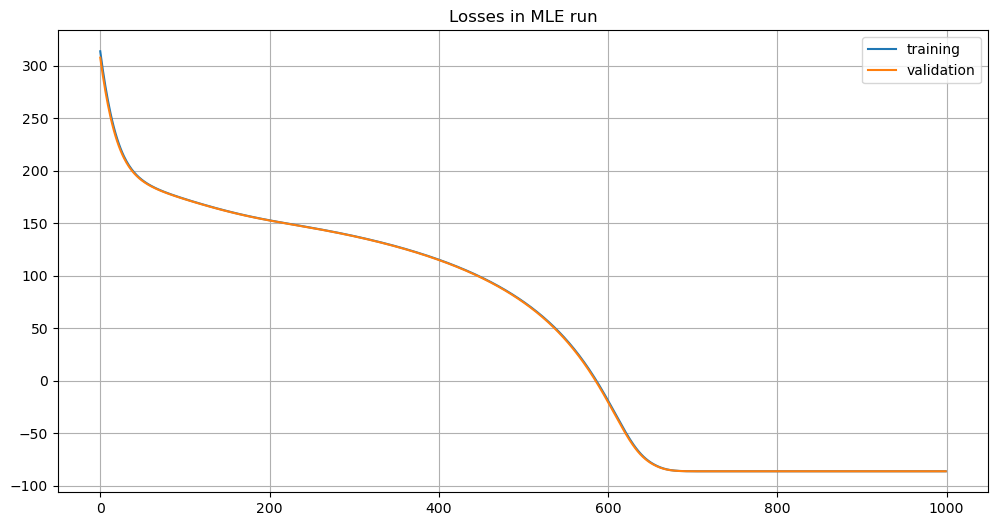

param_a MLE = 5.020e+00 vs ground truth = 5.000e+00
param_b MLE = -9.986e-01 vs ground truth = -1.000e+00
param_noise MLE = 1.021e-01 vs ground truth = 1.000e-01


In [11]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(training_losses, label='training')
ax.plot(validation_losses, label='validation')
ax.set_title(f'Losses in MLE run')
ax.grid()
ax.legend()
plt.show()

print(f'param_a MLE = {pyro.param("param_a"):.3e} vs ground truth = {a.item():.3e}')
print(f'param_b MLE = {pyro.param("param_b"):.3e} vs ground truth = {b.item():.3e}')
print(f'param_noise MLE = {pyro.param("param_noise"):.3e} vs ground truth = {noise.item():.3e}')

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
2 : learnable posterior distributions with SVI
</div>

Now we posit that the parameters are R.V. and perform SVI

### Stochastic Variational Inference framework

Here, we use a `guide` (ie an approximate posterior) as we define priors and look for posterior approximation via a parametric family.

`pyro.infer.SVI` is the main class for Stochastic Variational Inference in Pyro.

- arguments:
  - `model` : the probabilistic model that defines the joint distribution $p_{\theta}(x,z) = p_{\theta}(x \vert z)p(z)$ that defines the priors and the likelihood. Can use parameters.
  - `guide` : this is the approximate posterior $q_{\phi}(z)$, defines the parametric family used for the approximate posterior.
  - `optim`: optim algorithm, typically Adam, handles gradient steps.
  - `loss` : the objective function to be minimzed. Typically `Trace_ELBO` (which reduces to log-likelihood below as there is no approximate posterior).
    - `Trace_ELBO` has a `num_particles` argument that defines the number of samples used for the estimation of the expectation in the ELBO calculation (impacts the variance of the estimate and the computation load)

- `svi.step()` : uses `guide` and `model` to compute the ELBO, stores the gradient in the the Pyro Store,  perform a gradient step, return the scalar value of the loss.

- `svi.evaluate_loss()` : compute and return the loss, does not compute nor apply gradients.

`pyro.plate` is the Pyro's representation of the plate notation in graphical models.

It is a **context manager** that informs Pyro which parts of the model should be considered conditionnally indepedent.
- the set of random variables inside the `with pyro.plate(..)`are conditionally independent given all variables outside the plate.
- allows vectorization on GPU
- adding the `subsample_size` (`with pyro.plate("data", size=len(X), subsample_size=batch_size)): ...`) allows the use of mini-batches in large datasets.

(`pyro.markov` is a different context manager for time-series, where there is a Markov dependency between time steps)

In [12]:
# model : updated with priors declared with pyro.sample

def model(X, y=None):
    
    # inputs: ----------------------
    #   X : torch.tensor(size,1)
    #   y : torch.tensor(size,1) if provided
    
    # priors ------------------------
    param_a = pyro.sample("a", dist.Normal(0.0,1.0))
    param_b = pyro.sample("b", dist.Normal(0.0,1.0))
    
    # Trick : using a HalfNormal for the standard deviation param_noise
    # creates gradient instability as the reparametrization trick does not apply well on HalfNormal
    # so we use a log Normal prior instead 
    # (ie Normal then exponentiate for the likelihood computation)
    log_noise_std = pyro.sample("log_noise_std", dist.Normal(0.0,1.0)) # this is what will be stored in the param store
    param_noise = torch.exp(log_noise_std)  # this is what is used for the likelihood computation
    
    # gaussian likelihood ----------------------------
    means = X * param_a + param_b
    with pyro.plate("data", len(X)):
        y_hat = pyro.sample("obs", dist.Normal(means, param_noise), obs=y)
    # return is optional :
    #   - If y is None, this is a sample (tensor)
    #   - If y is given, this is the log likelihood
    
    return y_hat

The `guide` function declares the **approximate posterior family** for the SVI.
It serves as the container for all the learnable parameters and stochastic *sites* (latent variables) that the define the approximate posterior.

- it must define a *surrogate* probability distribution for each single latent variable (= unobserved) `pyro.sample` defined in the `model`. Names must be the same.
- no likelihood calculation, ie no `pyro.sample("obs",...)` or RV with `obs=y`. 
- the distributions within `guide` must be parameterized by `pyro.param` : those are the variational parameters $\phi$ that will be learnt during the SVI.
- the posterior can be factorized (mean-field approximation) or not.
- the `guide` signature must be exactly the same as `model` (ie `(X, y=None)` for example). This allows alignment for the different handlers.

In [13]:
# approximate posterior for a,b and noise
# here, mean-field approximation - posteriors factorize
# NB : just posteriors, no likelihood !

def q_phi(X, y=None):
    
    # a : gaussian posterior with learnable parameters a_loc and a_scale
    a_loc = pyro.param("a_loc", torch.tensor((0.0)).to(device))
    a_scale = pyro.param("a_scale", torch.tensor((0.1)).to(device), constraint=constraints.positive)
    pyro.sample("a", dist.Normal(a_loc, a_scale))
    
    # b : gaussian posterior with learnable parameters b_loc and b_scale
    b_loc = pyro.param("b_loc", torch.tensor((0.0)).to(device))
    b_scale = pyro.param("b_scale", torch.tensor((0.1)).to(device), constraint=constraints.positive)
    pyro.sample("b", dist.Normal(b_loc, b_scale))
    
    # noise : gaussian posterior for the log noise standard deviation
    log_noise_std_loc = pyro.param("log_noise_std_loc", torch.tensor((-2.0)).to(device))
    log_noise_std_scale = pyro.param("log_noise_std_std", torch.tensor(0.1).to(device), constraint=constraints.positive)
    pyro.sample("log_noise_std", dist.Normal(log_noise_std_loc, log_noise_std_scale))
    return

In [14]:
pyro.clear_param_store() # Clear old parameters

# optimizer
optimizer = Adam(
    {"lr": 1e-2}
)

# the SVI engine
K = 5 # number of samples used for the estimation of the expectation
svi = SVI(
    model=model,
    guide=q_phi,
    optim=optimizer,
    loss=Trace_ELBO(num_particles=K)
)

In [15]:
n_epochs = 5000
training_losses = []
validation_losses = []

for step in range(n_epochs):
    # perform the training and evaluation
    loss = svi.step(X,y)
    eval_loss = svi.evaluate_loss(X,y)
    # log
    training_losses.append(loss)
    validation_losses.append(eval_loss)
    # report out
    print(f'Epoch {step+1:<6} / {n_epochs:<6} - loss = {loss:.3e} - val loss = {eval_loss:.3e}')

Epoch 1      / 5000   - loss = 1.287e+04 - val loss = 9.281e+03
Epoch 2      / 5000   - loss = 1.202e+04 - val loss = 1.120e+04
Epoch 3      / 5000   - loss = 1.144e+04 - val loss = 8.361e+03
Epoch 4      / 5000   - loss = 1.056e+04 - val loss = 1.198e+04
Epoch 5      / 5000   - loss = 1.103e+04 - val loss = 9.550e+03
Epoch 6      / 5000   - loss = 9.928e+03 - val loss = 1.183e+04
Epoch 7      / 5000   - loss = 1.076e+04 - val loss = 8.151e+03
Epoch 8      / 5000   - loss = 1.014e+04 - val loss = 9.286e+03
Epoch 9      / 5000   - loss = 8.328e+03 - val loss = 7.792e+03
Epoch 10     / 5000   - loss = 9.256e+03 - val loss = 1.117e+04
Epoch 11     / 5000   - loss = 9.369e+03 - val loss = 8.906e+03
Epoch 12     / 5000   - loss = 9.950e+03 - val loss = 9.105e+03
Epoch 13     / 5000   - loss = 7.841e+03 - val loss = 8.053e+03
Epoch 14     / 5000   - loss = 7.905e+03 - val loss = 8.041e+03
Epoch 15     / 5000   - loss = 7.837e+03 - val loss = 8.475e+03
Epoch 16     / 5000   - loss = 8.616e+03

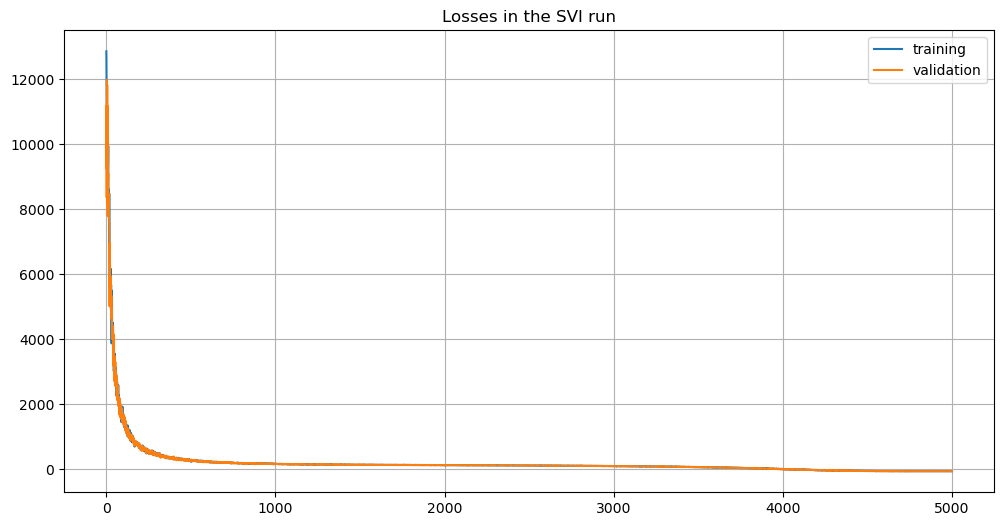

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(training_losses, label='training')
ax.plot(validation_losses, label='validation')
ax.grid()
ax.set_title(f'Losses in the SVI run')
ax.legend()
plt.show()

In [17]:
# retrieve posterior distribution parameters
parameters_store = pyro.get_param_store()

for name, value in parameters_store.items():
    print(f'{name} = {value:.3e}')
    
print(f'Ground truth : a = {a.item():.3f}, b = {b.item():.3f}, noise = {noise.item():.3f}, log noise = {torch.log(noise).item():.3f}')

a_loc = 5.011e+00
a_scale = 2.016e-02
b_loc = -1.001e+00
b_scale = 1.189e-02
log_noise_std_loc = -2.229e+00
log_noise_std_std = 8.487e-02
Ground truth : a = 5.000, b = -1.000, noise = 0.100, log noise = -2.303


A `pyro.poutine` is a wrapper or context manager that intercepts and modifies the behavior of Pyro primitives such as `pyro.sample` and `pyro.param`. 

- `pyro.poutine.trace` runs a `model` and a `guide` ($q_{\phi}$) and generates a data structure called a **Trace** : RV names, sampled values, distribution used, log prob, whether the RV is observed, etc.
- the `.nodes` attribute of the `Trace` object is a dictionary where each key corresponds to a primitive's name.
- the `Trace` generated is typically an input for other `pyro.poutine` such as `pyro.poutine.replay` :
  - trace the `guide` : `posterior_trace = poutine.trace(q_phi).get_trace(X)`
  - replay the model so it uses the samples from $q_{\phi}$ : `with poutine.replay(trace=posterior_trace): predicted_y_vector = model(X, y=None)`

The `trace` poutine can be used as a function wrapper or a context manager:
- **as a wrapper** : `guide_trace = pyro.poutine.trace(posterior_sampler_guide).get_trace(X_new)`
- **as a context manager** : `with pyro.poutine.trace() as tr:
trace = tr.get_trace()`

NB : one can code a specific `posterior_sampler` similar to the `guide` for the `Trace` execution : this can be done to 1/ clarify the separation between the training objective of the `guide` and the sampling objective of the `posterior_sampler`, and 2/ remove training-specific elements used in the `guide` and that have no value when sampling.

In [18]:
# here, we want to draw samples from the trained model on known X's

import pyro.poutine as poutine

N_SAMPLES=1000
N_POINTS = X.shape[0]

# place holder for predictions.
# at each point, draw samples of the predicted value.
y_preds = torch.zeros((N_POINTS, N_SAMPLES)).to(device)

for s in range(N_SAMPLES):
    # STEP 1: Trace the execution of the prediction guide.
    # The trace records the *value* of the sampled parameters (a, b, log_noise_std).
    # posterior_trace = poutine.trace(posterior_sampler).get_trace(X)
    # NB : here we used the q_phi guide/approximate posterior, and 
    #       did not write a specific simpler posterior sampler
    posterior_trace = poutine.trace(q_phi).get_trace(X)
    
    # STEP 2: Use the Replay Poutine on the Model.
    # This forces the Model to use the parameter values recorded in guide_trace.
    with poutine.replay(trace=posterior_trace):
        # STEP 3: Execute the Model to draw a prediction.
        # Calling model(X) with y=None tells the 'obs' site to draw a sample 
        # (the predicted y) using the replayed (fixed) parameters.
        predicted_y_vector = model(X, y=None) 
    
    # STEP 4: Store the resulting vector of predictions for all N_POINTS
    y_preds[:, s] = predicted_y_vector.squeeze()

print(f"Finished sampling {N_SAMPLES} predictive vectors.")

Finished sampling 1000 predictive vectors.


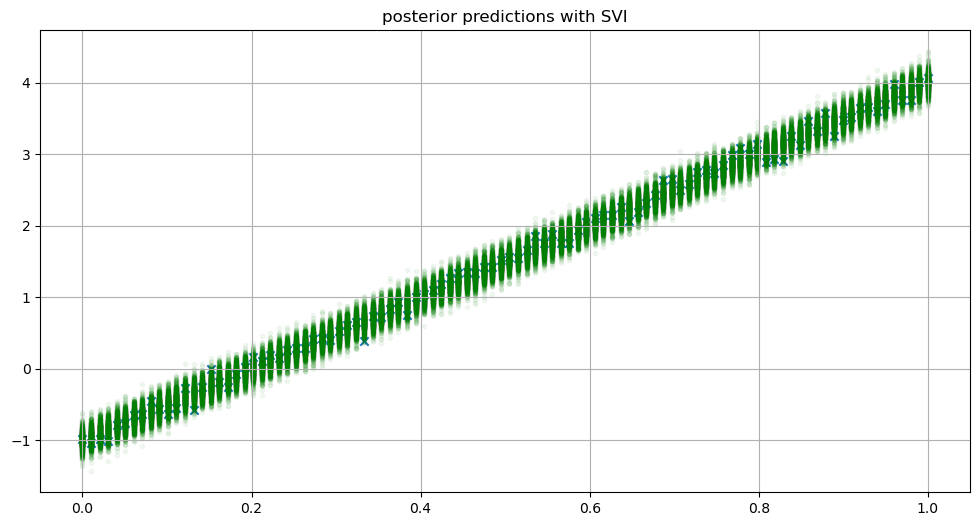

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(X.cpu(),y.cpu(), marker='x', label='ground truth')
ax.grid()
ax.set_title(f'posterior predictions with SVI')
for s in range(N_SAMPLES):
    ax.scatter(X.cpu(), y_preds[:,s].detach().cpu(), alpha=0.05, color='green', marker='.')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
3 : learnable posterior distributions with MCMC
</div>

Now we still posit that the parameters are R.V. and use MCMC methods to sample from the **true** posterior distributions.

The class is `MCMC`with (among others) the following arguments:
- `kernel` : type `MCMCKernel` : can be NUTS, HMC, RWMH (random walk Metropolis Hastings...)
- `num_samples` : number of samples wanted after warmup/burn-in
- `warmup_steps` : number of warm up steps to have the Markov Chain converge
- `jit_compile` : If True, uses PyTorch's JIT compiler to speed up the model's forward and gradient calculations. Requires a static computational graph. Defaults to False.
- `disable_progbar` : If True, suppresses the tqdm progress bar during the MCMC.run() call. Defaults to False.

Zoom on JIT compilation:

1. What JIT Compilation Does
- **Tracing**: When `jit_compile=True`, the Pyro/PyTorch system executes the core computational graph of the NUTS algorithm (which includes the gradient calculations over your model) once, and the JIT compiler records (or "traces") all the operations performed on the tensors.
- **Optimization**: This recorded graph is then optimized and compiled into a highly efficient execution unit.
- **Execution**: Subsequent steps of the NUTS chain use this compiled code block instead of re-interpreting the Python/PyTorch code every time.

1. JIT's Requirement: Static Graph
The primary constraint of using `jit_compile=True` is that your model and guide must be traceable. This means:
- No Data-Dependent Control Flow: You cannot have conditional logic (if/else statements, loops) where the condition depends on the data (tensor values) within the model that changes per iteration. The computational graph must be static.
- Static Shapes: Tensor sizes should generally remain constant during the MCMC run.
- For simple models like Bayesian linear regression, 'jit_compile=True' usually works without issue and provides a substantial speedup, especially when using a GPU.

In [20]:
# reset the Store parameters
pyro.clear_param_store()

In [21]:
# STEP 1 : define the NUTS kernel - takes the generative model itself.
nuts_kernel = NUTS(
    model=model,
    jit_compile=True, # True for speed, False for debugging
)

In [22]:
# STEP 2 : define a MCMC sampler with the above kernel
# does NOT use the model. This is merely the executor of the MCMCKernel
N_MCMC_SAMPLES = 2000
N_BURNIN = 500

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=1,
    initial_params=None
)

In [23]:
# STEP3 : run the sampler
MCMC_runner.run(X,y)

Sample: 100%|██████████| 2500/2500 [00:18, 135.90it/s, step size=3.40e-01, acc. prob=0.930]


In [24]:
# STEP 4 : Extract and analyse the samples

# get samples
posterior_samples = MCMC_runner.get_samples()

a_samples = posterior_samples.get('a')
b_samples = posterior_samples.get('b')
log_noise_std_samples = posterior_samples.get('log_noise_std')
noise_std_samples = torch.exp(log_noise_std_samples)

Ground truth : a = 5.000, b = -1.000, noise = 0.100


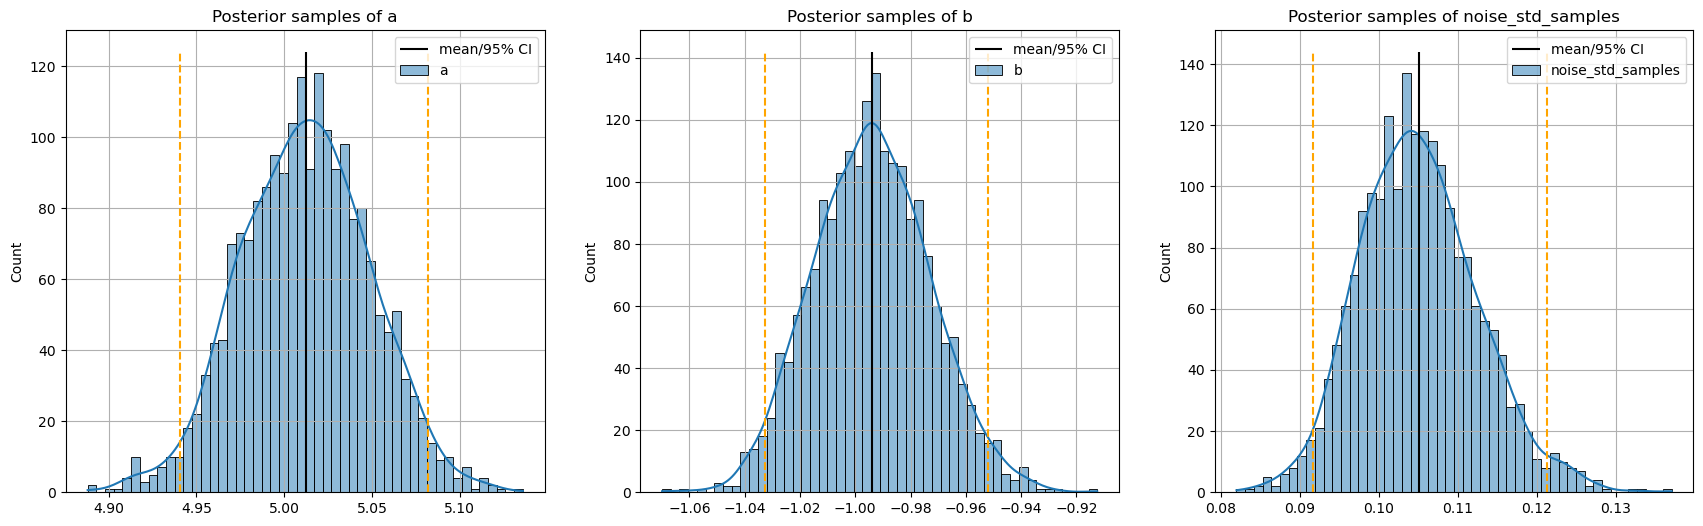

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))

dict = {
    'a' : a_samples,
    'b' : b_samples,
    'noise_std_samples' : noise_std_samples
}

for i, (name, data) in enumerate(dict.items()):
    samples = data.cpu().numpy()
    sample_mean = samples.mean()
    sample_ci_low = torch.quantile(data, 0.025).item()
    sample_ci_high = torch.quantile(data, 0.975).item()
    
    sns.histplot(data=samples, bins=50, kde=True, label=f'{name}', ax=ax[i])
    ax[i].vlines([sample_mean, sample_ci_low, sample_ci_high],
                ymin=0, ymax=ax[i].get_ylim()[1],
                colors=['k', 'orange', 'orange'],
                linestyles=['-', '--', '--'],
                label='mean/95% CI')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(f"Posterior samples of {name}")
    
print(f'Ground truth : a = {a.item():.3f}, b = {b.item():.3f}, noise = {noise.item():.3f}')

In [26]:
# STEP 5 : POSTERIOR PREDICTIVE SAMPLING

# here we use some boilerplate code to reconstruct a trace out of the samples,
# so we can use the poutine.replay afterwards
def make_trace_from_mcmc_samples(i):
    
    # A clean approach is to use a trace template
    def latent_sampler_template():
        # This MUST mirror the latent pyro.sample sites (=RV) in your actual model
        _ = pyro.sample("a", dist.Normal(0, 1)) 
        _ = pyro.sample("b", dist.Normal(0, 1))
        _ = pyro.sample("log_noise_std", dist.Normal(0, 1))

    # Run the template function to get a VALID trace graph
    template_trace = poutine.trace(latent_sampler_template).get_trace()
    
    # loop over all the latent variables
    for name in template_trace.nodes:
        # Check if the node is a latent variable we sampled in MCMC
        if name in posterior_samples and template_trace.nodes[name]['type'] == 'sample':
            
            # Get the MCMC sample
            mcmc_sample_value = posterior_samples[name][i].squeeze()
            
            # Replace the value in the template trace with the MCMC sample
            template_trace.nodes[name]['value'] = mcmc_sample_value
            
            # Ensure no observation (should already be True, but for safety)
            template_trace.nodes[name]['is_observed'] = False
            
            # Ensure the log_prob is correctly sized (or zeroed out)
            template_trace.nodes[name]['log_prob'] = torch.zeros_like(mcmc_sample_value)

    # 3. Return the modified, but structurally VALID, trace
    return template_trace

In [27]:
# STEP 5 - continued

# place holder for predictions
y_preds = torch.zeros((N_POINTS, N_MCMC_SAMPLES))

# loop on the samples, draw a prediction at for each set of posterior a,b,noise
for i in range(N_MCMC_SAMPLES):
    # form the Trace associated to the i-th sample
    mcmc_trace = make_trace_from_mcmc_samples(i)
    # draw an output sample with the posterior samples
    with poutine.replay(trace=mcmc_trace):
        predicted_y_vector = model(X, y=None)
    # store
    y_preds[:,i] = predicted_y_vector.squeeze()

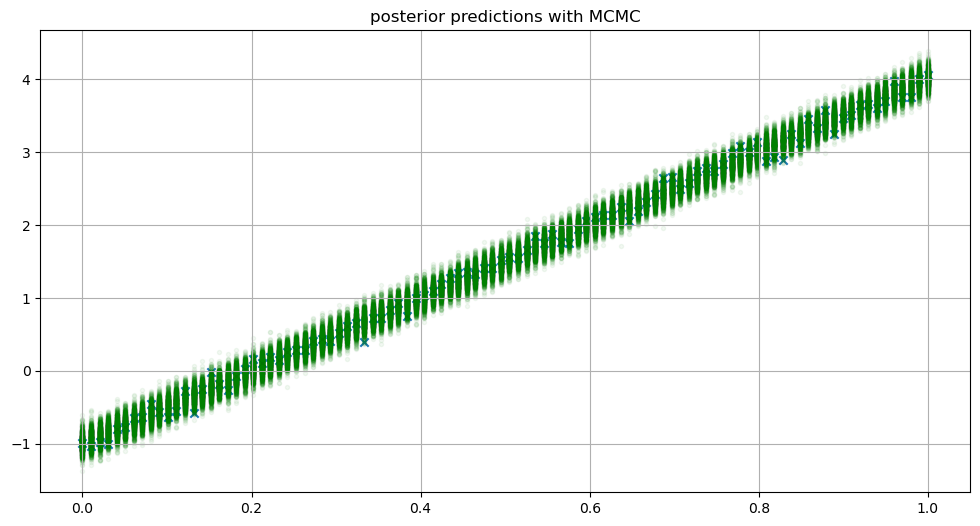

In [28]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(X.cpu(),y.cpu(), marker='x', label='ground truth')
ax.grid()
ax.set_title(f'posterior predictions with MCMC')
for s in range(N_SAMPLES):
    ax.scatter(X.cpu(), y_preds[:,s].detach().cpu(), alpha=0.05, color='green', marker='.')
plt.show()